In [62]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
import string
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
import xgboost as xgb

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical


In [12]:
import pandas as pd

df = pd.read_csv('/kaggle/input/ag-news-classification-dataset/train.csv')
df.columns = ['label', 'title', 'description']
df['text'] = df['title'] + " " + df['description']
df = df[['label', 'title', 'description', 'text']]
df.head()

,label,title,description,text
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",Wall St. Bears Claw Back Into the Black (Reute...
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,Carlyle Looks Toward Commercial Aerospace (Reu...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,Oil and Economy Cloud Stocks' Outlook (Reuters...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,Iraq Halts Oil Exports from Main Southern Pipe...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...","Oil prices soar to all-time record, posing new..."


In [13]:
import nltk
nltk.data.path.append("/usr/share/nltk_data")  
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re, string

In [14]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [ ]:
def preprocess(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words]
    return " ".join(tokens)

In [16]:
df['clean_text'] = df['text'].apply(preprocess)
df.head()

,label,title,description,text,clean_text
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",Wall St. Bears Claw Back Into the Black (Reute...,wall st bear claw back black reuters reuters s...
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,Carlyle Looks Toward Commercial Aerospace (Reu...,carlyle look toward commercial aerospace reute...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,Oil and Economy Cloud Stocks' Outlook (Reuters...,oil economy cloud stock outlook reuters reuter...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,Iraq Halts Oil Exports from Main Southern Pipe...,iraq halt oil export main southern pipeline re...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...","Oil prices soar to all-time record, posing new...",oil price soar alltime record posing new menac...


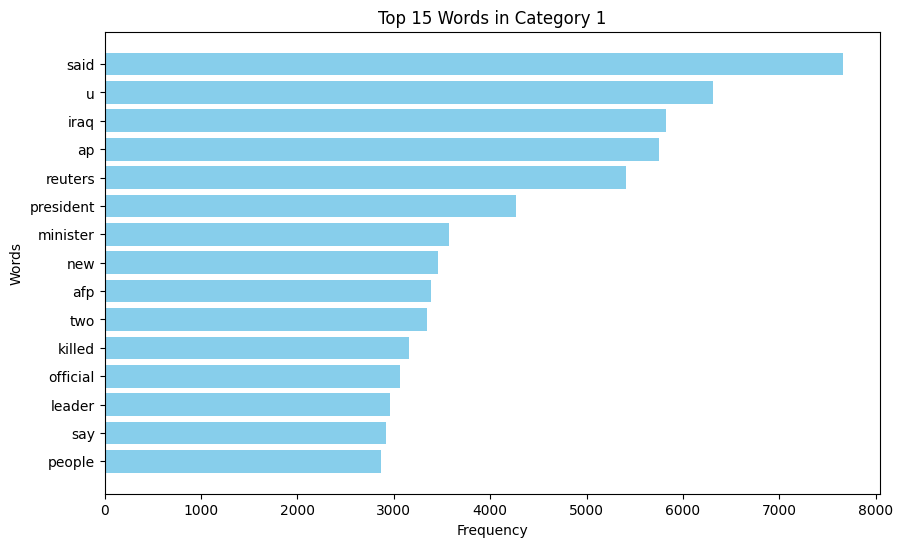

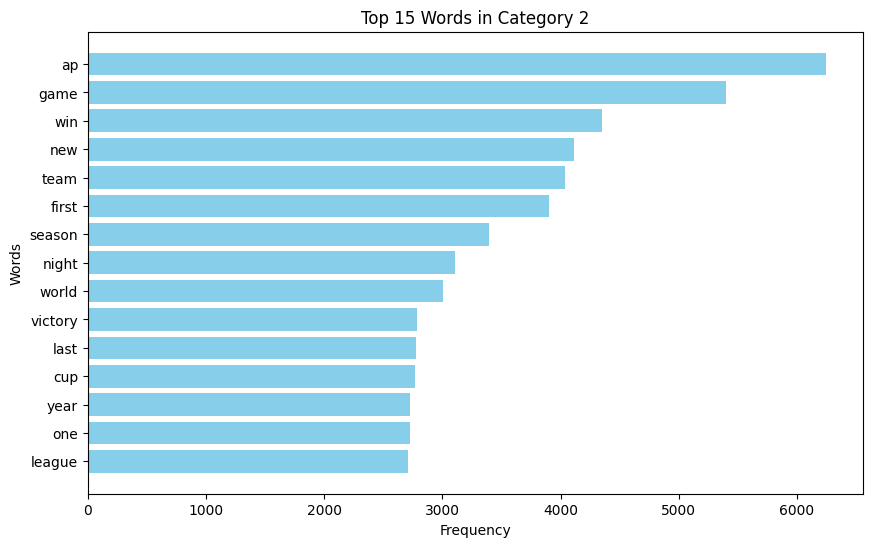

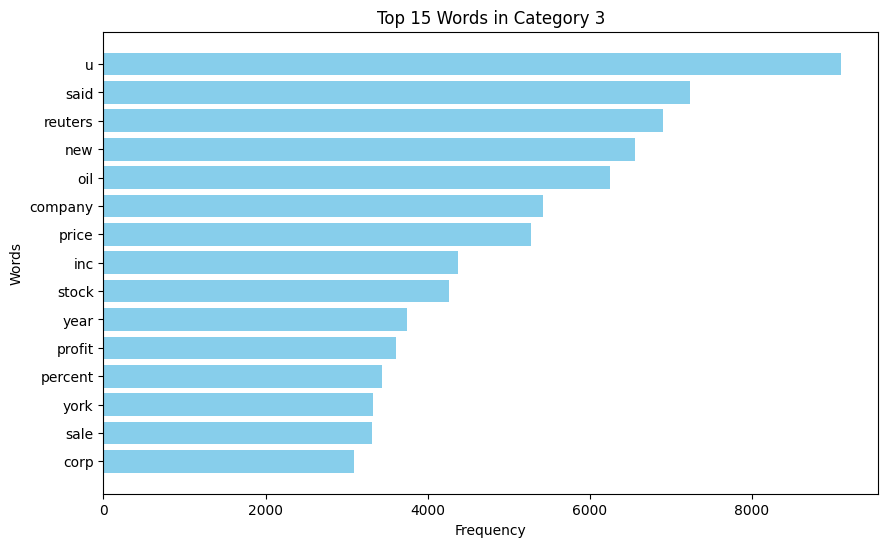

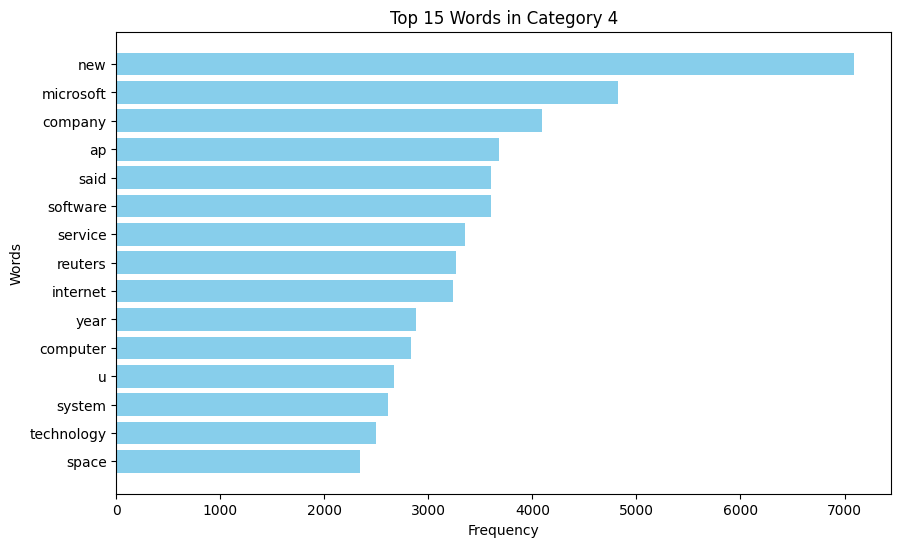

In [38]:
import matplotlib.pyplot as plt
from collections import Counter

TOP_N = 15

for label in sorted(df['label'].unique()):
    text = " ".join(df[df['label'] == label]['clean_text'])
    words = text.split()
    word_freq = Counter(words)
    common_words = word_freq.most_common(TOP_N)
    words, counts = zip(*common_words)
    plt.figure(figsize=(10, 6))
    plt.barh(words[::-1], counts[::-1], color='skyblue')
    plt.title(f"Top {TOP_N} Words in Category {label}")
    plt.xlabel("Frequency")
    plt.ylabel("Words")
    plt.show()


In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

In [20]:
tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['clean_text']).toarray()

In [21]:
y = df['label'] - 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [52]:
from sklearn.linear_model import LogisticRegression

clf_lr = LogisticRegression(max_iter=1000)
clf_lr.fit(X_train, y_train)

y_pred_lr = clf_lr.predict(X_test)  

In [59]:
model_xgb = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
model_xgb.fit(X_train, y_train)
y_pred_xgb = model_xgb.predict(X_test)

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical

In [27]:
y_train_cat = to_categorical(y_train, num_classes=4)
y_test_cat = to_categorical(y_test, num_classes=4)

In [31]:
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

model = Sequential()
model.add(Input(shape=(X_train.shape[1],))) 
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(4, activation='softmax')) 


In [32]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train_cat, epochs=5, batch_size=64, validation_split=0.1)

Epoch 1/5
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 14s 9ms/step - accuracy: 0.8156 - loss: 0.5437 - val_accuracy: 0.9093 - val_loss: 0.2625
Epoch 2/5
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - accuracy: 0.9254 - loss: 0.2256 - val_accuracy: 0.9086 - val_loss: 0.2604
Epoch 3/5
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.9411 - loss: 0.1736 - val_accuracy: 0.9125 - val_loss: 0.2679
Epoch 4/5
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.9513 - loss: 0.1434 - val_accuracy: 0.9111 - val_loss: 0.2896
Epoch 5/5
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.9617 - loss: 0.1114 - val_accuracy: 0.9102 - val_loss: 0.3253


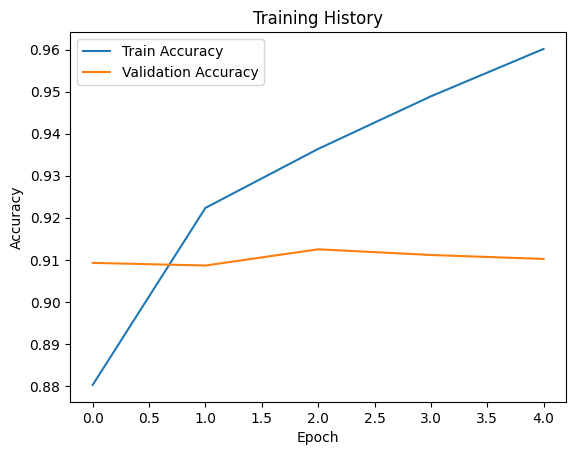

In [34]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Training History")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [33]:
loss, accuracy = model.evaluate(X_test, y_test_cat)
print("Neural Network Accuracy:", accuracy)

750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9077 - loss: 0.3263
Neural Network Accuracy: 0.90645831823349


In [56]:
y_pred_nn = model.predict(X_test)  
y_pred_nn_labels = np.argmax(y_pred_nn, axis=1)

750/750 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step


In [57]:
from sklearn.metrics import accuracy_score, classification_report

print("Logistic Regression:")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))

print("\nXGBoost:")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb))

print("\nNeural Network (Keras):")
print("Accuracy:", accuracy_score(y_test, y_pred_nn_labels))
print(classification_report(y_test, y_pred_nn_labels))


Logistic Regression:
Accuracy: 0.9082916666666667
              precision    recall  f1-score   support

           0       0.92      0.90      0.91      5956
           1       0.95      0.98      0.96      6058
           2       0.87      0.88      0.88      5911
           3       0.89      0.88      0.89      6075

    accuracy                           0.91     24000
   macro avg       0.91      0.91      0.91     24000
weighted avg       0.91      0.91      0.91     24000


XGBoost:
Accuracy: 0.8874166666666666
              precision    recall  f1-score   support

           0       0.91      0.88      0.90      5956
           1       0.92      0.95      0.94      6058
           2       0.86      0.86      0.86      5911
           3       0.86      0.85      0.86      6075

    accuracy                           0.89     24000
   macro avg       0.89      0.89      0.89     24000
weighted avg       0.89      0.89      0.89     24000


Neural Network (Keras):
Accuracy: 0.9064